<!--
tags: [tutorial]
description: Code Executors
-->

# Code Executors

**This chapter is a work in progress, will be updated once the containerized code executor is ready]**

In the [last chapter](./human-in-the-loop), 
we used two agents powered by a large language model (LLM) 
to play a game. It was a fun exercise, but LLM by itself can only
generate text -- it cannot interact with its environment or reliably perform
logical operations like arithmetic. 

In this chapter, we introduce code executor, an AutoGen's agent component that 
takes input messages with code blocks, performs execution, and output messages
with the results.

**Note**: Different from many other agent frameworks, AutoGen's code executor
can power an entire role of an agent: it can take input messages, execute code,
and output messages -- just like LLM.

In [ ]:
import os
import datetime
from IPython.display import Image
from autogen import ConversableAgent

Here is an example of a code executor agent:

In [1]:
code_executor_agent = ConversableAgent(
    "code_executor_agent",
    llm_config=False,  # Turn off LLM for this agent.
    code_execution_config={"executor": "ipython-embedded"},
    human_input_mode="ALWAYS",  # Always take human input for this agent for safety.
)

The code executor agent is initialized with the `ipython-embedded` code executor.
This executor runs an IPython kernel in the background and can execute Python
code.
Just like an agent powered by LLM, the code executor agent can also respond to 
messages.

In [13]:
reply = code_executor_agent.generate_reply(
    messages=[
        {
            "role": "user",
            "content": """
```python
import random
print(random.randint(1, 100))
```
""",
        }
    ],
    sender=ConversableAgent("user", llm_config=False),
)
print(reply)


>>>>>>>> NO HUMAN INPUT RECEIVED.

>>>>>>>> USING AUTO REPLY...
exitcode: 0 (execution succeeded)
Code output: 93



When you run the previous code block, you will be prompted for a human feedback,
which gives you an option to intercept message because the code executor can run
arbitrary code. It is important to have a human in the loop.

[Discuss containerization once that piece is ready.]

## Agent and Coding

Writing and executing code is necessary for many complex tasks such as 
data analysis, machine learning, and mathematical modeling. 
In AutoGen, coding is a conversation between a code writer agent and a 
code executor agent, mirroring the interaction between a programmer and a
code interpreter.

The code writer agent can be powered by an LLM such as GPT-4 with code-writing
capability.
The following is an agent with a code writer role specified 
using `system_message`.

In [2]:
code_writer_agent = ConversableAgent(
    "code_writer",
    system_message="You are an AI assistant. You write code in markdown code "
    "blocks. You do not execute code yourself, but always ask me to execute code "
    "for you in an IPython kernel.",
    llm_config={"config_list": [{"model": "gpt-4", "api_key": os.environ["OPENAI_API_KEY"]}]},
    code_execution_config=False,  # Turn off code execution for this agent.
)

Here is an example of solving a math problem through a conversation
between the code writer and the code executor:

In [22]:
result = code_executor_agent.initiate_chat(
    code_writer_agent,
    message="Write Python code to calculate the 14th Fibonacci number.",
)

code_executor_agent (to code_writer):

Write Python code to calculate the 14th Fibonacci number.

--------------------------------------------------------------------------------

>>>>>>>> USING AUTO REPLY...
code_writer (to code_executor_agent):

Alright, here's a Python function that uses the iterative approach to calculate the N-th Fibonacci number:

```python
def fibonacci(n):
    a, b = 0, 1
    for _ in range(n):
        a, b = b, a + b
    return a

# calculate the 14th Fibonacci number
fibonacci_14 = fibonacci(14)
fibonacci_14
```
Would you please execute this code?

--------------------------------------------------------------------------------

>>>>>>>> NO HUMAN INPUT RECEIVED.

>>>>>>>> USING AUTO REPLY...
code_executor_agent (to code_writer):

exitcode: 0 (execution succeeded)
Code output: 377

--------------------------------------------------------------------------------

>>>>>>>> USING AUTO REPLY...
code_writer (to code_executor_agent):

The 14th Fibonacci number is 37

During the previous chat session, human input was requested each time
the code executor agent responded to ensure that the code was safe to execute.

Now we can try a more complex example that involves querying the web.
Let's say we want to get the the stock prices year-to-date for
Tesla and Meta (formerly Facebook). We can also use the two agents
with several iterations of conversation.


In [4]:
today = datetime.datetime.now().strftime("%Y-%m-%d")
result = code_executor_agent.initiate_chat(
    code_writer_agent, message=f"Today is {today}. Plot a chart for Tesla's and Microsoft's stock prices YTD."
)

code_executor_agent (to code_writer):

Today is 2024-02-16. Plot a chart for Tesla's and Microsoft's stock prices YTD.

--------------------------------------------------------------------------------

>>>>>>>> USING AUTO REPLY...
code_writer (to code_executor_agent):

I would love to, but as an text-based AI, I don't have real-time access to data from the internet, including stock prices. However, I can certainly guide you through the steps of doing this using Python. 

First, you will need to install `yfinance`, which will allow us to download historical market data from Yahoo Finance. You can do this by running `!pip install yfinance`.

Next, you should import the required libraries and download the data:

```python
import yfinance as yf
import matplotlib.pyplot as plt

# Download historical data as dataframes
tesla_stock = yf.download('TSLA', start='2024-01-01', end='2024-02-16')
microsoft_stock = yf.download('MSFT', start='2024-01-01', end='2024-02-16')
```
Once you have the data,

Let's take a look at the chart that was generated.

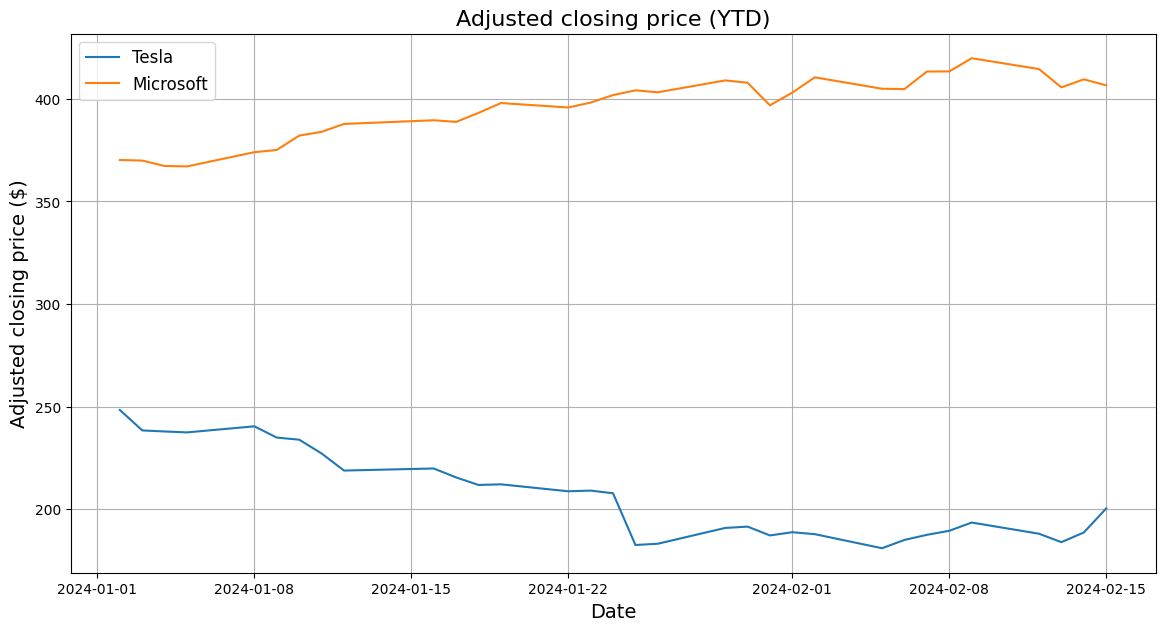

In [5]:
Image("31c88163ca9f414ca4ccb20045e4aa84.png")

## Containerization

Code executor is a powerful tool, but it can also be dangerous because it can affect the environment it runs it. For example, it can delete files, send data to a remote server, or even mine cryptocurrency. To mitigate these risks, we can run the code executor in a container. This way, the code executor can only access the resources that are explicitly given to it.

## Summary

[Talk about tool executor and reference a separate chapter.]